In [1]:
from os.path import join
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot
import seaborn as sn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn import svm, metrics
from joblib import dump

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab-Notebooks/

/content/drive/MyDrive/Colab-Notebooks


In [ ]:
action_codes = ["A050","A051","A052","A053","A054","A055","A056","A057","A058","A059","A060"]

In [ ]:
def show_confusion_matrix_and_save(y_pred, y_actual,title, save=False):
    #
    # show confusion matrix for mis-classification on validation set
    #
    confusion = confusion_matrix(y_actual, y_pred, normalize='pred');
    # print(confusion)

    df_cm = DataFrame(confusion, index=action_codes, columns=action_codes)

    fig, ax = pyplot.subplots(figsize=(9, 9))
    ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, ax=ax)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    ax.set_title(title)
    pyplot.show()

    if save:
      fig.savefig("SVM_ntu_rgb_d_kp_feat_output/{}.jpg".format(title))

In [ ]:
def build_and_save_SVM_Classifier(setting='cs',skips=8):
    #
    # build the SVM classifier for 11 mutual actions (A050-A060)
    # on ntu_rgb_d dataset
    # Input:
    #   -setting -cross-subject 'cs' or cross-view 'cv' setting
    #   -skips -indicate a specific feature set corresponding with
    #   a specific value of 'skips' parameter when doing feature engineering
    #   Example: skips=8, the distance between the next selected frame and
    #                     current selected frame is equal to 8

    # build the dataset path based on arguments of the function
    train_dataset = "dataset-NTU-RGB-D/frm_mod_skips"
    if setting == "cs":
        train_dataset = "{}{}/cross-subject/train/".format(train_dataset,skips)
    elif setting == "cv":
        train_dataset = "{}{}/cross-view/train/".format(train_dataset,skips)

    # load dataset
    df_ds = pd.DataFrame()
    for action_code in action_codes:
        df = pd.read_csv(join(train_dataset, action_code + ".csv"), index_col=0)

        # check if any NaN, remove and save back to .csv file
        if df.isnull().values.any():
            df = df.dropna()
            df.to_csv(join(train_dataset, action_code + ".csv"))

        labels = [action_code for i in range(len(df.index))]
        df.insert(df.shape[1], "label", labels)
        df_ds = df_ds.append(df)

    # print(df_ds.shape)

    # separate features and labels
    X = df_ds.iloc[:, :-1]
    y = df_ds.iloc[:, -1]

    # apply scaling to entire dataset
    trans = StandardScaler()
    X = trans.fit_transform(X)

    # apply one-hot coding for label
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)

    # save encoded classes
    encoded_classes = list(encoder.classes_)
    dump(encoded_classes, 'ntu_saved_models/encoded-classes.joblib')

    # train test split
    # split train and test set
    X_train, X_val, y_train, y_val = train_test_split(X, encoded_y, test_size=0.33, shuffle=True)

    # create SVM classifier
    clf = svm.SVC(kernel='rbf')

    # cross validation
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    # plot_learning_curve(clf, 'Learning curve for humiact model', X, y, ylim=(0.4, 1.01),
    #                     cv=cv, n_jobs=4)

    # create appropriate folder name for saving classifier beforehand
    clf_folder = "ntu_saved_models/frm_mod_skips{}/{}/".format(skips, setting)
    # clf_folder = join(dir_path,clf_folder)
    # # create directory if not exists
    # if not exists(clf_folder):
    #     os.makedirs(clf_folder)

    print ("Model is fitting...")
    clf.fit(X_train,y_train)
    print ("Done!")

    clf_full_path = clf_folder + "SVM-model-with-keypfea.joblib"
    # dump classifier to file
    dump(clf, clf_full_path)

    # predict the response
    print ("Predicting train/val set...")
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_val)
    print ("Done!")

    # show confusion matrix for mis-classification on training set
    show_confusion_matrix_and_save(y_pred_train, y_train, "SVM- Training set ({},skips{})".format(setting,skips), save=True)
    # show confusion matrix for mis-classification on validation set
    show_confusion_matrix_and_save(y_pred, y_val,"SVM- Validation set ({},skips{})".format(setting,skips), save=True)

    train_acc = metrics.accuracy_score(y_train, y_pred_train)
    val_acc = metrics.accuracy_score(y_val, y_pred)
    # save train/val accuracy to txt file
    file_name = "SVM_ntu_rgb_d_kp_feat_output/train_val_accuracy.txt"

    with open(file_name, "a") as f:
      f.write("setting={},skips={}: train_acc= {}, val_acc= {}\n".format(setting,skips,train_acc,val_acc))

    # Model Accuracy: how often does the classifier predict correctly?
    print("Training accuracy:", train_acc)
    print("Validation accuracy:", val_acc)

Model is fitting...
Done!
Predicting train/val set...
Done!


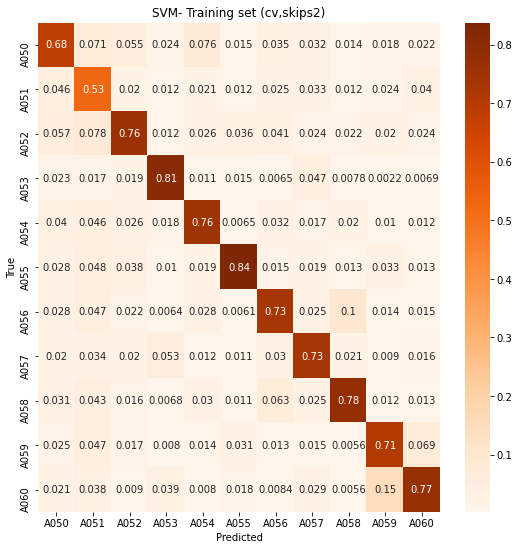

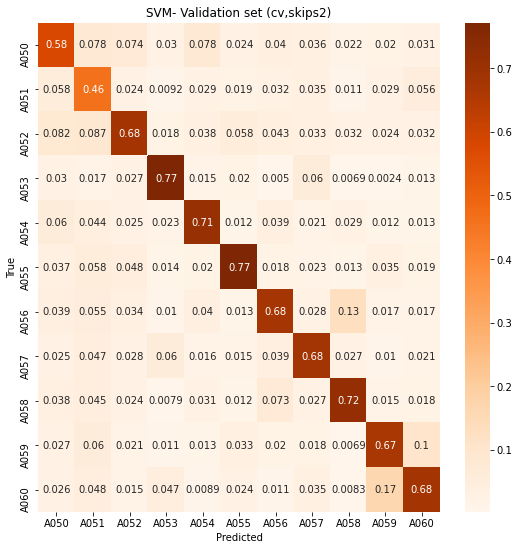

Training accuracy: 0.7310884027158631
Validation accuracy: 0.6703731699554424


In [ ]:
# build the model without PCA
build_and_save_SVM_Classifier(setting='cv',skips=2)

In [ ]:
# from IPython.core.debugger import set_trace

def build_and_save_SVM_Classifier_withPCA(setting='cs',skips=8):
    #
    # build the SVM classifier for 11 mutual actions (A050-A060)
    # on ntu_rgb_d dataset
    # Input:
    #   -setting -cross-subject 'cs' or cross-view 'cv' setting
    #   -skips -indicate a specific feature set corresponding with
    #   a specific value of 'skips' parameter when doing feature engineering
    #   Example: skips=8, the distance between the next selected frame and
    #                     current selected frame is equal to 8

    # build the dataset path based on arguments of the function
    train_dataset = "dataset-NTU-RGB-D/frm_mod_skips"
    if setting == "cs":
        train_dataset = "{}{}/cross-subject/train/".format(train_dataset,skips)
    elif setting == "cv":
        train_dataset = "{}{}/cross-view/train/".format(train_dataset,skips)

    # load dataset
    df_ds = pd.DataFrame()
    for action_code in action_codes:
        df = pd.read_csv(join(train_dataset, action_code + ".csv"), index_col=0)

        # check if any NaN, remove and save back to .csv file
        if df.isnull().values.any():
            df = df.dropna()
            df.to_csv(join(train_dataset, action_code + ".csv"))

        labels = [action_code for i in range(len(df.index))]
        df.insert(df.shape[1], "label", labels)
        df_ds = df_ds.append(df)

    # print(df_ds.shape)

    # separate features and labels
    X = df_ds.iloc[:, :-1]
    y = df_ds.iloc[:, -1]

    # apply scaling to entire dataset
    trans = StandardScaler()
    X = trans.fit_transform(X)

    # apply one-hot coding for label
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)

    # save encoded classes
    encoded_classes = list(encoder.classes_)
    dump(encoded_classes, 'ntu_saved_models/encoded-classes.joblib')

    # train test split
    # split train and test set
    X_train, X_val, y_train, y_val = train_test_split(X, encoded_y, test_size=0.33, shuffle=True)

    # set_trace()
    # apply PCA
    # initialize pca instance
    pca = PCA(0.95)

    # fit PCA on training set
    pca.fit(X_train)

    # apply mapping (transform) to both training and test set
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)

    dump(pca, 'ntu_saved_models/SVM-PCA-transform.joblib')
        
    # create SVM classifier
    clf = svm.SVC(kernel='rbf')

    # cross validation
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    # plot_learning_curve(clf, 'Learning curve for humiact model', X, y, ylim=(0.4, 1.01),
    #                     cv=cv, n_jobs=4)

    # create appropriate folder name for saving classifier beforehand
    clf_folder = "ntu_saved_models/frm_mod_skips{}/{}/".format(skips, setting)
    # clf_folder = join(dir_path,clf_folder)
    # # create directory if not exists
    # if not exists(clf_folder):
    #     os.makedirs(clf_folder)

    clf.fit(X_train,y_train)

    clf_full_path = clf_folder + "SVM-model-with-keypfea-withPCA.joblib"
    # dump classifier to file
    dump(clf, clf_full_path)

    # predict the response
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_val)

    # show confusion matrix for mis-classification on training set
    show_confusion_matrix(y_pred_train, y_train, "SVM- Training set")
    # show confusion matrix for mis-classification on validation set
    show_confusion_matrix(y_pred, y_val,"SVM- Validation set")

    # Model Accuracy: how often is the classifier correct?
    print("Training accuracy:", metrics.accuracy_score(y_train, y_pred_train))
    print("Validation accuracy:", metrics.accuracy_score(y_val, y_pred))

In [ ]:
# build the model with PCA
build_and_save_SVM_Classifier_withPCA(setting='cs',skips=0)